### The tf.data API

In [1]:
import tensorflow as tf

In [2]:
X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset  # contains 10 items. Same as tf.data.Dataset.range(10) except int64 instead of int32

2024-05-01 10:10:37.699464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-05-01 10:10:37.699479: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-01 10:10:37.699483: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-01 10:10:37.699513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-01 10:10:37.699529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
X_nested = {"a":([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
dataset

<_TensorSliceDataset element_spec={'a': (TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)), 'b': TensorSpec(shape=(), dtype=tf.int32, name=None)}>

In [5]:
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### Chaining Transformations

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [7]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [8]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [9]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### Shuffling the data

In [10]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### Interleaving Lines from Multiple Files

In [11]:
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [12]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [13]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [14]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [15]:
# Create a dataset containing only these filepaths
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
filepath_dataset

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [16]:
for item in filepath_dataset:
    print(item)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [17]:
# Read from 5 files at a time and interleave their lines
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers
)

In [18]:
dataset

<_InterleaveDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [19]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


### Preprocessing the Data

In [20]:
# extra code – compute the mean and standard deviation of each feature
# You can do this on a large enough random sample of the dataset
# or use a Keras preprocessing layer instead

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [21]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [22]:
[0.] * n_inputs + [tf.constant([], dtype=tf.float32)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>]

In [23]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting Everything Together

In [24]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads
    )
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [25]:
def dataset_fn(ds):
    return ds.filter(lambda x: x < 5)

dataset = tf.data.Dataset.range(100)
dataset = dataset.apply(dataset_fn)
list(dataset.as_numpy_iterator())

[0, 1, 2, 3, 4]

### Using the Dataset with Keras

In [26]:
# The sets will be shuffled at each epoch, although we don't need that
# for the validation set and the test set

train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [27]:
# extra code – for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5


2024-05-01 10:10:38.661842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


    363/Unknown - 1s 3ms/step - loss: 2.6544

2024-05-01 10:10:39.880873: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4641067209795008085
2024-05-01 10:10:39.880884: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7599901653305288511
2024-05-01 10:10:39.880891: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11278114144852147582


363/363 [==============================] - 2s 4ms/step - loss: 2.6544 - val_loss: 4.5288
Epoch 2/5
  1/363 [..............................] - ETA: 57s - loss: 0.5524

2024-05-01 10:10:40.217531: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12103845684665516900
2024-05-01 10:10:40.217543: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11001571414435339478
2024-05-01 10:10:40.217549: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5234434393647047760


363/363 [==============================] - 1s 3ms/step - loss: 0.4448 - val_loss: 0.6681
Epoch 3/5
363/363 [==============================] - 2s 4ms/step - loss: 0.4190 - val_loss: 2.2339
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4054 - val_loss: 0.6993
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3990 - val_loss: 0.3839


In [29]:
test_mse = model.evaluate(test_set)
test_mse

162/162 [==============================] - 0s 2ms/step - loss: 0.3828


2024-05-01 10:10:46.530865: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12103845684665516900
2024-05-01 10:10:46.530880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11001571414435339478
2024-05-01 10:10:46.530886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5234434393647047760


0.3827539384365082

In [30]:
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)
y_pred


3/3 [==============================] - 0s 4ms/step


2024-05-01 10:10:46.671439: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10207953094677331768


array([[1.0113883 ],
       [2.1750536 ],
       [1.5112715 ],
       [1.368623  ],
       [2.0514345 ],
       [3.0058894 ],
       [1.2915287 ],
       [3.0270174 ],
       [0.89958966],
       [0.7503557 ],
       [1.6922365 ],
       [0.669923  ],
       [3.527317  ],
       [2.0697384 ],
       [0.94441754],
       [2.661568  ],
       [0.72669303],
       [1.8762802 ],
       [1.9955766 ],
       [4.14713   ],
       [5.88331   ],
       [1.6875575 ],
       [3.2840548 ],
       [1.3558714 ],
       [1.7791233 ],
       [2.4759235 ],
       [3.1471663 ],
       [1.599561  ],
       [0.84223694],
       [1.0019134 ],
       [1.1464603 ],
       [2.1285033 ],
       [5.277351  ],
       [2.0922093 ],
       [1.8530228 ],
       [1.8168007 ],
       [2.8817058 ],
       [1.7730131 ],
       [2.0312543 ],
       [3.4318378 ],
       [2.3243525 ],
       [1.9922332 ],
       [1.061842  ],
       [2.3696468 ],
       [1.5794036 ],
       [3.8104718 ],
       [0.52765155],
       [2.353

In [31]:
# extra code – defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [32]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 1/5

2024-05-01 10:10:56.352941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


Epoch 5/5

### The TFRecord Format

In [33]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [34]:
# Read TFRecord files into a tf.data.TFRecordDataset
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [35]:
# Compressed TFRecord file
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options=options) as f:
    f.write(b"Compress, compress, compress!")

### A Brief Introduction to Protocol Buffers

In [36]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting person.proto


In [37]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [38]:
%ls person*

person.desc    person.proto   person_pb2.py


In [39]:
# Use the access classes generated by protoc
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])
print(person)

name: "Al"
id: 123
email: "a@b.com"



In [40]:
person.name

'Al'

In [41]:
person.name = "Alice"
person.email[0]

'a@b.com'

In [42]:
person.email.append("c@d.com")

In [43]:
# Serialize person to a byte string
serialized = person.SerializeToString()
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [44]:
person2 = Person()
person2.ParseFromString(serialized)

27

In [45]:
person == person2

True

### TensorFlow Protobufs

Here's the `Example` protobuf definition:

```proto
syntax = "proto3";
message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```


In [46]:
# Here's a tf.train.Example representing the same person as earlier
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }
    )
)

In [47]:
# Serialize the Example to a bytes string and write it to a TFRecord file
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

### Loading and Parsing Examples

In [48]:
my_dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"])
my_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [49]:
# The TFRecordDataset contains the serialized byte strings

for item in my_dataset:
    print(item)

tf.Tensor(b'\n@\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n\x1e\n\x06emails\x12\x14\n\x12\n\x07a@b.com\n\x07c@d.com\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{', shape=(), dtype=string)
tf.Tensor(b'\n@\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n\x1e\n\x06emails\x12\x14\n\x12\n\x07a@b.com\n\x07c@d.com\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{', shape=(), dtype=string)
tf.Tensor(b'\n@\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n\x1e\n\x06emails\x12\x14\n\x12\n\x07a@b.com\n\x07c@d.com\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{', shape=(), dtype=string)
tf.Tensor(b'\n@\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n\x1e\n\x06emails\x12\x14\n\x12\n\x07a@b.com\n\x07c@d.com\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{', shape=(), dtype=string)
tf.Tensor(b'\n@\n\x11\n\x04name\x12\t\n\x07\n\x05Alice\n\x1e\n\x06emails\x12\x14\n\x12\n\x07a@b.com\n\x07c@d.com\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{', shape=(), dtype=string)


In [50]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tenso

In [51]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [52]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [53]:
# Parse many examples in batches
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Ten

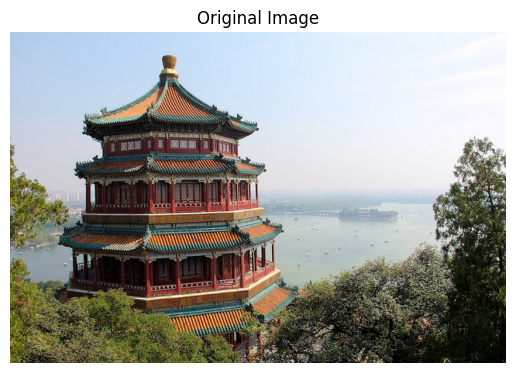

In [54]:
# Example of encoding an image with tf.io.encode_jpeg()
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [55]:
data = tf.io.encode_jpeg(img)
data  # is a byte string which we could put in a BytesList inside an Example (with data.numpy())

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\xab\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\

In [56]:
data.numpy()

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\xab\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x9

In [57]:
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
serialized_example

b'\n\xf9\xd3\x08\n\xf5\xd3\x08\n\x05image\x12\xea\xd3\x08\n\xe6\xd3\x08\n\xe2\xd3\x08\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\xab\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUV

In [58]:
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

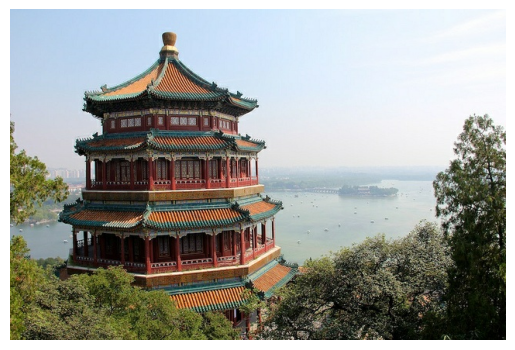

In [59]:
# Get back the original image
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

### Handling Lists of Lists Using the SequenceExample Protobuf

Here is the definition of the SequenceExample protobuf:

```proto
message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

### Keras Preprocessing Layers

**The Normalization Layer**

In [60]:
with tf.device("/cpu:0"):
    norm_layer = tf.keras.layers.Normalization()
    model = tf.keras.models.Sequential([
        norm_layer,
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=2e-3))
    norm_layer.adapt(X_train)  # computes the mean and variance of every feature
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 536us/step - loss: 2.7064 - val_loss: 0.9093
Epoch 2/5
363/363 [==============================] - 0s 430us/step - loss: 0.7380 - val_loss: 1.5254
Epoch 3/5
363/363 [==============================] - 0s 422us/step - loss: 0.6415 - val_loss: 1.1530
Epoch 4/5
363/363 [==============================] - 0s 427us/step - loss: 0.6164 - val_loss: 0.8179
Epoch 5/5
363/363 [==============================] - 0s 439us/step - loss: 0.6022 - val_loss: 0.5755


In [61]:
# Use the Normalization layer in a standalone fashion so it doesn't have 
# to run once per epoch during training
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [62]:
with tf.device("/cpu:0"):
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=2e-3))
    model.fit(X_train_scaled, y_train, epochs=5,
              validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 0s 531us/step - loss: 2.5122 - val_loss: 2.3297
Epoch 2/5
363/363 [==============================] - 0s 421us/step - loss: 0.8103 - val_loss: 1.8775
Epoch 3/5
363/363 [==============================] - 0s 419us/step - loss: 0.6965 - val_loss: 1.3615
Epoch 4/5
363/363 [==============================] - 0s 420us/step - loss: 0.6598 - val_loss: 0.8851
Epoch 5/5
363/363 [==============================] - 0s 418us/step - loss: 0.6334 - val_loss: 0.5962


In [63]:
# For production, wrap the normalization layer and the model into a new model
# so that normalization happens automatically with new instances
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3] # pretend we have new, unscaled instances
y_pred = final_model(X_new) # preprocesses the data and makes predictions
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.93272436],
       [1.648466  ],
       [2.209648  ]], dtype=float32)>

In [64]:
# extra code – creates a dataset to demo applying the norm_layer using map()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)

In [65]:
dataset = dataset.map(lambda X, y: (norm_layer(X), y))
list(dataset.take(1))

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397898, -1.0778134 , -0.94338703,  0.0148516 ,  0.02073434,
          -0.5729169 ,  0.9292593 , -1.4221286 ],
         [ 0.7519828 , -1.8688954 ,  0.40547714, -0.23327833,  1.8614666 ,
           0.20516504, -0.91654944,  1.0966994 ],
         [-0.4146912 ,  0.02970134,  0.8180874 ,  1.056782  , -0.08786613,
          -0.29983333,  1.3087262 , -1.697002  ],
         [ 1.7188952 , -1.315138  ,  0.3266428 , -0.21955259, -0.337921  ,
          -0.11146676, -0.9821362 ,  0.94177276],
         [-0.96207213, -1.2360299 , -0.05625897, -0.03124549,  1.709061  ,
          -0.3025704 , -0.8041136 ,  1.326592  ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

**The Discretization Layer**

In [66]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [67]:
# Alterantively, use num_bins
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

In [68]:
discretize_layer.bin_boundaries

ListWrapper([10.0, 36.999996185302734])

**The CategoryEncoding Layer**

In [69]:
# one-hot encoding
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [70]:
# multi-hot encoding
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)  # e.g. in the first row the categories 0 and 1 are present

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [71]:
# output_mode="count"
# e.g. in the second row, category '2' appeared two times
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

In [72]:
# multi-hot and count encoding lose information (we don't know which feature
# each category came from). So, let's tweak the category identifiers so
# they don't overlap
two_age_categories = two_age_categories + [0, 3] # adds 3 to the second feature
two_age_categories

array([[1, 3],
       [2, 5],
       [2, 3]])

In [73]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories)
# The first three columns correspond to the first feature and the last three
# correspond to the second feature

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [74]:
# extra code – shows another way to one-hot encode each feature separately
two_age_categories = two_age_categories - [0, 3] # restore original vector
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3,
                                                output_mode="one_hot")
# we use tf.transpose() to handle each feature separately
tf.keras.layers.concatenate([onehot_layer(cat)
                             for cat in tf.transpose(two_age_categories)])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [75]:
two_age_categories

array([[1, 0],
       [2, 2],
       [2, 0]])

In [76]:
tf.transpose(two_age_categories)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[1, 2, 2],
       [0, 2, 0]])>

In [77]:
for cat in tf.transpose(two_age_categories):
    print(cat)

tf.Tensor([1 2 2], shape=(3,), dtype=int64)
tf.Tensor([0 2 0], shape=(3,), dtype=int64)


In [78]:

onehot_layer(cat)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [79]:
# extra code – shows another way to do this, using tf.one_hot() and Flatten
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [80]:
tf.one_hot(two_age_categories, depth=3)

<tf.Tensor: shape=(3, 2, 3), dtype=float32, numpy=
array([[[0., 1., 0.],
        [1., 0., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.]]], dtype=float32)>

In [81]:
two_age_categories

array([[1, 0],
       [2, 2],
       [2, 0]])

**The StringLookup Layer**

In [84]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

In [87]:
# Output one-hot vectors
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

In [88]:
# Using num_oov_indices to distinguish some of the unknown categories
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])
# Categories 0-4 are reserved for the oov buckets

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

**The Hashing Layer**

In [89]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]])>

### Encoding Categorical Features Using Embeddings

In [90]:
# Embedding layer for 5 categories and 2 dimensions
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.02633258,  0.00995606],
       [-0.04634593,  0.036244  ],
       [ 0.02633258,  0.00995606]], dtype=float32)>

In [100]:
# Embeddings for categorical text attributes
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])

lookup_and_embed(np.array([["<1H OCEAN"], ["ISLAND"], ["<1H OCEAN"]]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.04920168, -0.00913466],
       [-0.0233652 ,  0.00932218],
       [-0.04920168, -0.00913466]], dtype=float32)>

**Putting everything together**

In [101]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000)
y_valid = np.random.rand(2_000, 1)

In [103]:
with tf.device("/cpu:0"):
    num_input = tf.keras.layers.Input(shape=[8], name="num")
    cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
    cat_embeddings = lookup_and_embed(cat_input)
    encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
    outputs  = tf.keras.layers.Dense(1)(encoded_inputs)
    model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
    model.compile(loss="mse", optimizer="sgd")
    history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                        validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1265 - val_loss: 0.1107
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1013 - val_loss: 0.0958
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0915 - val_loss: 0.0896
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0875 - val_loss: 0.0869
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0856 - val_loss: 0.0854


### Text Preprocessing

In [104]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer.get_vocabulary()

['', '[UNK]', 'be', 'to', 'the', 'thats', 'question']

In [105]:
text_vec_layer(["Be good!", "Question: be or be?"])
# the first sentence is zero padded to match the length of the second one

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

In [106]:
ragged_vec_layer = tf.keras.layers.TextVectorization(ragged=True)
ragged_vec_layer.adapt(train_data)
ragged_vec_layer(["Be good!", "Question: be or be?"])

<tf.RaggedTensor [[2, 1], [6, 2, 1, 2]]>

In [107]:
# Using tf_idf encoding for the output of the TextVectorization layer
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])


<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

### Using Pretrained Language Model Components

In [108]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

### Image Preprocessing Layers

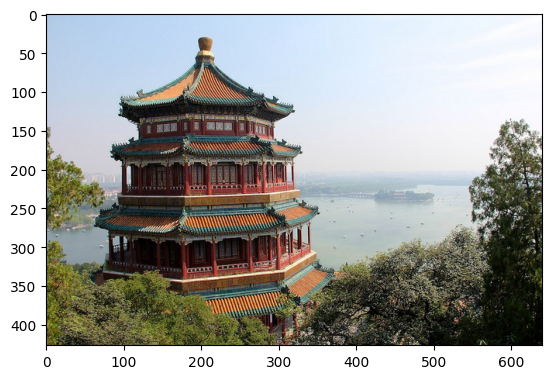

In [111]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)
plt.imshow(images[0])

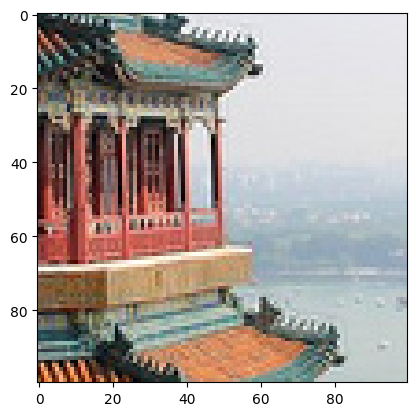

In [115]:
plt.imshow(cropped_images[0] / 255) # Divide with 255 to make the pixel values between 0.0 and 1.0

### The TensorFlow Datasets Project

In [116]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-01 13:01:26.837854: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 5/5 [00:04<00:00,  1.23 file/s]

Dataset mnist downloaded and prepared to /Users/nikolaoschachampis/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [117]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    # ... do something with the images and labels

In [118]:
# Convert dictionary to tuple
# We could also set as_supervised=True in load() call
mnist_train = mnist_train.shuffle(buffer_size=10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [120]:
# Complete example with loading, splitting and training
with tf.device("/cpu:0"):
    train_set, valid_set, test_set = tfds.load(
        name="mnist",
        split=["train[:90%]", "train[90%:]", "test"],
        as_supervised=True
    )
    train_set = train_set.shuffle(buffer_size=10_000, seed=42).batch(32).prefetch(1)
    valid_set = valid_set.batch(32).cache()
    test_set = test_set.batch(32).cache()
    tf.random.set_seed(42)
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                metrics=["accuracy"])
    history = model.fit(train_set, validation_data=valid_set, epochs=5)
    test_loss, test_accuracy = model.evaluate(test_set)
    test_loss, test_accuracy

Epoch 1/5
1688/1688 [==============================] - 1s 601us/step - loss: 9.9352 - accuracy: 0.8347 - val_loss: 6.3895 - val_accuracy: 0.8762
Epoch 2/5
1688/1688 [==============================] - 1s 401us/step - loss: 5.6204 - accuracy: 0.8776 - val_loss: 5.7579 - val_accuracy: 0.8733
Epoch 3/5
1688/1688 [==============================] - 1s 400us/step - loss: 5.0929 - accuracy: 0.8837 - val_loss: 5.5844 - val_accuracy: 0.8785
Epoch 4/5
1688/1688 [==============================] - 1s 445us/step - loss: 4.8080 - accuracy: 0.8859 - val_loss: 5.8957 - val_accuracy: 0.8800
Epoch 5/5
313/313 [==============================] - 0s 475us/step - loss: 5.6636 - accuracy: 0.8672
